In [1]:
##Verificando o dataset

import os

base_path = "/kaggle/input/smoke-fire-detection-yolo"
print("Conteúdo do diretório principal:")
for item in os.listdir(base_path):
    print("  ", item)

for subset in ["train", "val", "test"]:
    img_folder = os.path.join(base_path, "data", subset, "images")
    lbl_folder = os.path.join(base_path, "data", subset, "labels")
    num_imgs = len([f for f in os.listdir(img_folder) if f.lower().endswith((".jpg", ".png"))])
    num_lbls = len([f for f in os.listdir(lbl_folder) if f.endswith(".txt")])
    print(f"{subset.upper():>5} => {num_imgs} imagens em `{img_folder}`, {num_lbls} labels em `{lbl_folder}`")


Conteúdo do diretório principal:
   data.yaml
   data
TRAIN => 14122 imagens em `/kaggle/input/smoke-fire-detection-yolo/data/train/images`, 14122 labels em `/kaggle/input/smoke-fire-detection-yolo/data/train/labels`
  VAL => 3099 imagens em `/kaggle/input/smoke-fire-detection-yolo/data/val/images`, 3099 labels em `/kaggle/input/smoke-fire-detection-yolo/data/val/labels`
 TEST => 4306 imagens em `/kaggle/input/smoke-fire-detection-yolo/data/test/images`, 4306 labels em `/kaggle/input/smoke-fire-detection-yolo/data/test/labels`


In [2]:
##Importar o yolo

# Entrar na pasta raiz do notebook (caso não esteja)
%cd /kaggle/working

# Clonar YOLOv5
!git clone https://github.com/ultralytics/yolov5.git

/kaggle/working
Cloning into 'yolov5'...
remote: Enumerating objects: 17511, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17511 (delta 5), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17511/17511), 16.62 MiB | 29.19 MiB/s, done.
Resolving deltas: 100% (12000/12000), done.


In [3]:
##Instalar bibliotecas

%cd yolov5
!pip install -r requirements.txt

/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12

In [4]:
## Verificar o torch e o YOLO

import torch
from models.common import DetectMultiBackend
print("Torch versão:", torch.__version__)
print("YOLOv5 import OK!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch versão: 2.6.0+cu124
YOLOv5 import OK!


In [5]:
##Criar data/Dfire.yaml dentro do diretório yolov5
import os

yaml_path = "data/Dfire.yaml"
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

with open(yaml_path, "w") as f:
    f.write(
"""train: ../input/smoke-fire-detection-yolo/data/train/images
val:   ../input/smoke-fire-detection-yolo/data/val/images
test:  ../input/smoke-fire-detection-yolo/data/test/images

nc: 2
names: ['Smoke', 'Fire']
""")
print(f"Arquivo criado: {yaml_path}")
!sed -n '1,20p' data/Dfire.yaml

Arquivo criado: data/Dfire.yaml
train: ../input/smoke-fire-detection-yolo/data/train/images
val:   ../input/smoke-fire-detection-yolo/data/val/images
test:  ../input/smoke-fire-detection-yolo/data/test/images

nc: 2
names: ['Smoke', 'Fire']


In [6]:
# Este script cria o arquivo de configuração 'Dfire.yaml' 
##para o treinamento com o YOLOv5, especificando os caminhos das
##imagens de treino, validação e teste, além de especificar as classes
import os

train_images = "/kaggle/input/smoke-fire-detection-yolo/data/train/images"
val_images   = "/kaggle/input/smoke-fire-detection-yolo/data/val/images"
test_images  = "/kaggle/input/smoke-fire-detection-yolo/data/test/images"

yaml_path = "data/Dfire.yaml"
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

with open(yaml_path, "w") as f:
    f.write(
f"""train: {train_images}
val:   {val_images}
test:  {test_images}

nc: 2
names: ['Smoke', 'Fire']
""")
print(f"Arquivo atualizado: {yaml_path}")

Arquivo atualizado: data/Dfire.yaml


In [7]:
##Verificar o yaml
!sed -n '1,20p' data/Dfire.yaml

train: /kaggle/input/smoke-fire-detection-yolo/data/train/images
val:   /kaggle/input/smoke-fire-detection-yolo/data/val/images
test:  /kaggle/input/smoke-fire-detection-yolo/data/test/images

nc: 2
names: ['Smoke', 'Fire']


In [8]:
### Este script copia a configuração original do modelo YOLOv5s para um 
## novo arquivo adaptado e altera o número de classes de 
## 80 para 2, ajustando o modelo às classes específicas do projeto ('Smoke' e 'Fire').

import shutil

orig = "models/yolov5s.yaml"
dest = "models/yolov5s_dfire.yaml"
shutil.copy(orig, dest)

with open(dest, "r") as f:
    txt = f.read()
txt = txt.replace("nc: 80", "nc: 2")
with open(dest, "w") as f:
    f.write(txt)

print(f"Config de modelo pronto em: {dest}")

Config de modelo pronto em: models/yolov5s_dfire.yaml


In [9]:
!grep -n "nc:" models/yolov5s_dfire.yaml

4:nc: 2 # number of classes


In [10]:
## Treinamento do modelo com 100 épocas usando o conjunto de dados D-Fire

os.environ['WANDB_MODE'] = 'disabled'

!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 100 \
    --data data/Dfire.yaml \
    --cfg models/yolov5s_dfire.yaml \
    --weights yolov5s.pt \
    --name baseline_dfire \
    --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-06 20:32:31.637166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751833952.137908     109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751833952.264120     109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s_dfire.yaml, data=data/Dfire.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=dat

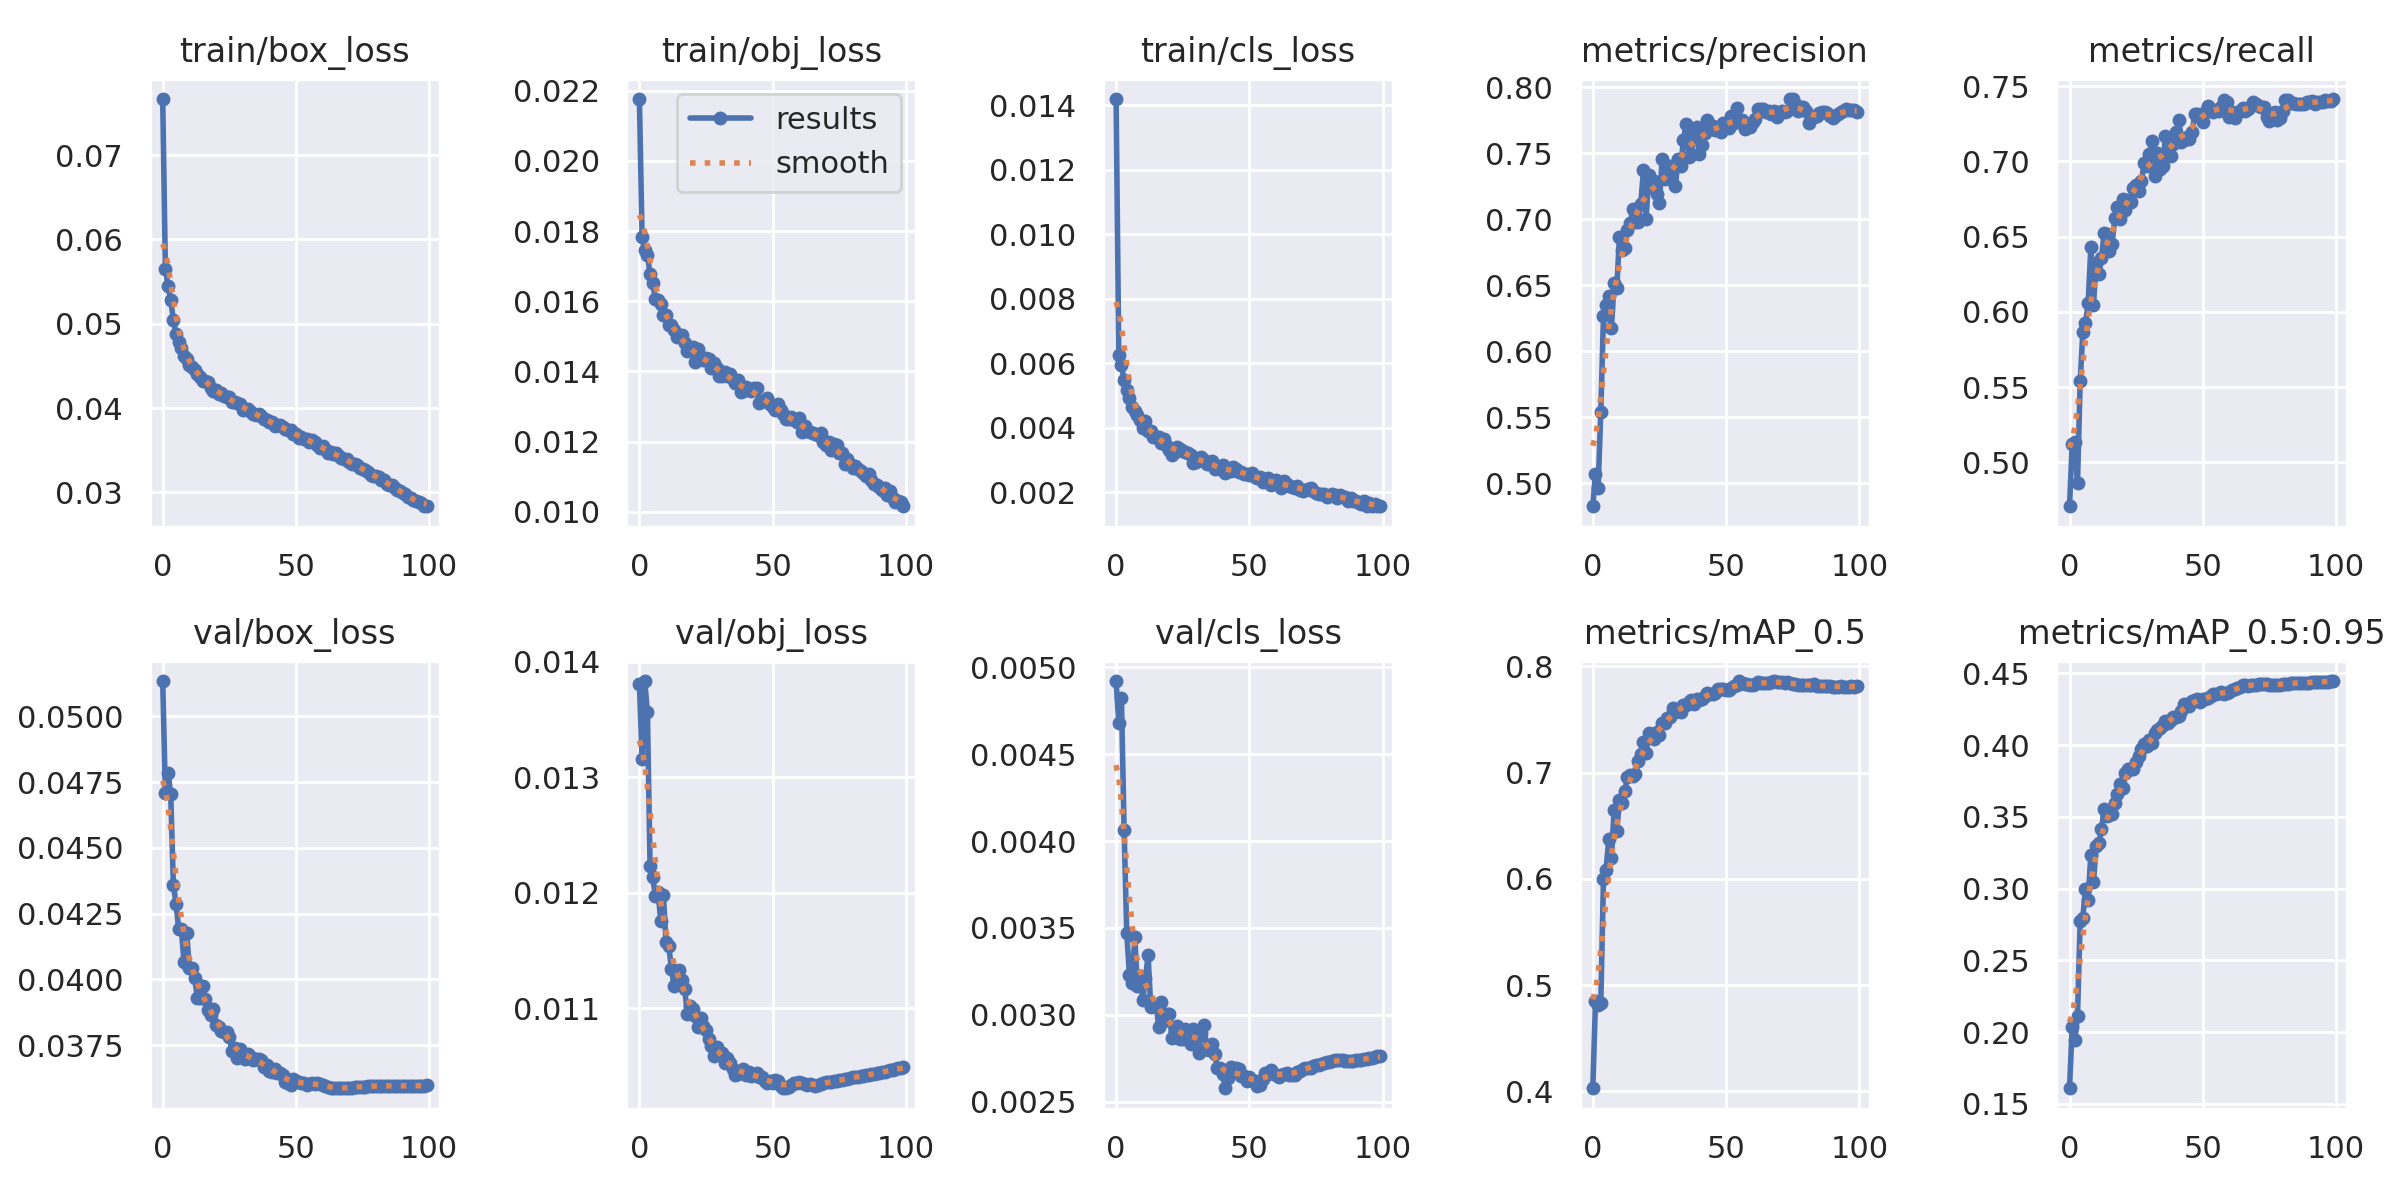

In [11]:
from IPython.display import Image, display
Image(filename='runs/train/baseline_dfire/results.png', width=800)

detect: weights=['runs/train/baseline_dfire/weights/best.pt'], source=/kaggle/input/smoke-fire-detection-yolo/data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=baseline_test_output, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s_dfire summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/4306 /kaggle/input/smoke-fire-detection-yolo/data/test/images/AoF06723.jpg: 384x640 (no detections), 32.7ms
image 2/4306 /kaggle/input/smoke-fire-detection-yolo/data/test/images/AoF06724.jpg: 352x640 (no detections), 32.2ms
image 3/4

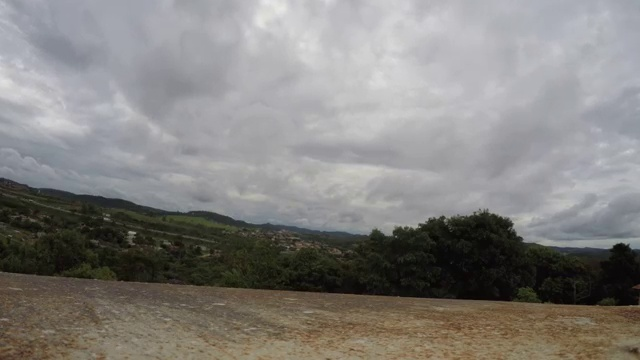

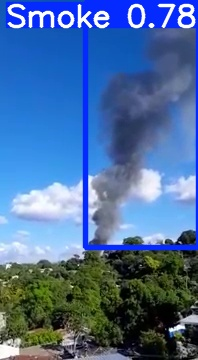

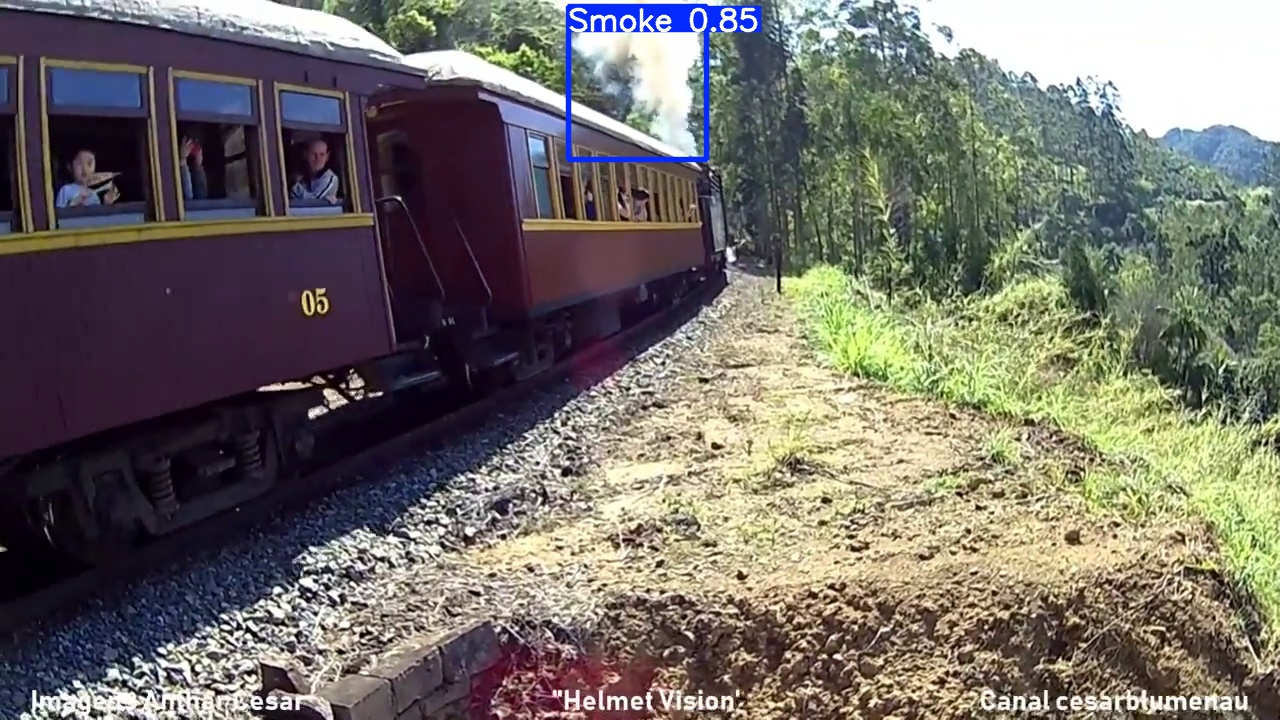

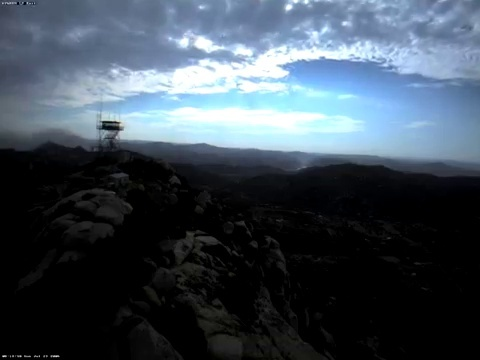

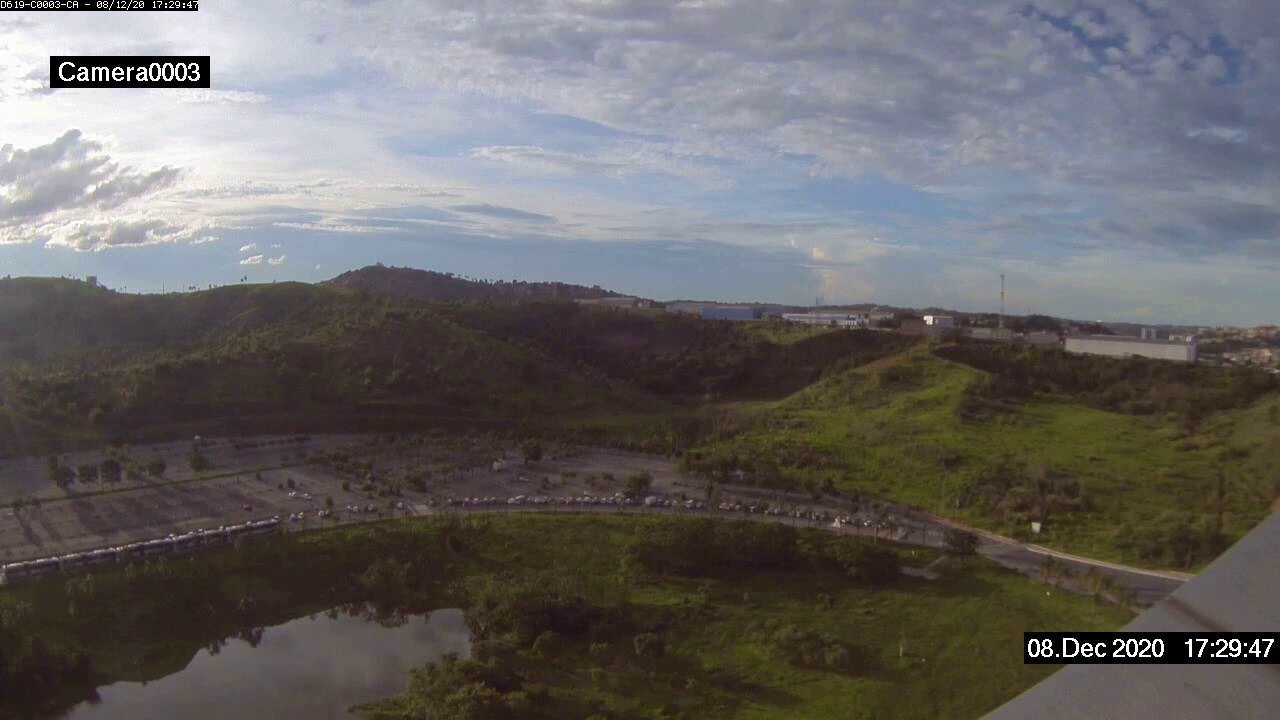

In [12]:
# Inference em imagens da pasta test
!python detect.py \
    --weights runs/train/baseline_dfire/weights/best.pt \
    --img 640 \
    --conf 0.25 \
    --source /kaggle/input/smoke-fire-detection-yolo/data/test/images \
    --name baseline_test_output

# Caminho onde as imagens preditas são salvas
pred_path = 'runs/detect/baseline_test_output'

# Mostrar algumas imagens preditas
for image_name in os.listdir(pred_path)[:5]:
    display(Image(filename=f'{pred_path}/{image_name}', width=600))


In [15]:
# Salva as métricas quantitativas
import pandas as pd
df = pd.read_csv('runs/train/baseline_dfire/results.csv').iloc[-1]
print(f"mAP@0.5  : {df['     metrics/mAP_0.5']:.4f}")
print(f"mAP@0.5:0.95  : {df['metrics/mAP_0.5:0.95']:.4f}")
print(f"Precisão : {df['   metrics/precision']:.4f}")
print(f"Recall   : {df['      metrics/recall']:.4f}")

mAP@0.5  : 0.7812
mAP@0.5:0.95  : 0.4446
Precisão : 0.7809
Recall   : 0.7414


In [17]:
# Avalia o conjunto test
!python val.py \
    --img 640 \
    --data data/Dfire.yaml \
    --task test \
    --weights runs/train/baseline_dfire/weights/best.pt \
    --name test_baseline

val: data=data/Dfire.yaml, weights=['runs/train/baseline_dfire/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=test_baseline, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s_dfire summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /kaggle/input/smoke-fire-detection-yolo/data/test/labels... 4295 
test: WARNING ⚠️ /kaggle/input/smoke-fire-detection-yolo/data/test/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0297]
test: WARNING ⚠️ /kaggle/input/smoke-fire-detection-yolo/data/test/images/WEB10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0078]
t

In [22]:
# Mede o FPS em CPU
import torch, cv2, random, time
from pathlib import Path
from yolov5.models.common import DetectMultiBackend

# --- caminhos e constantes ---
WEIGHTS  = "runs/train/baseline_dfire/weights/best.pt"
TEST_IMG = "/kaggle/input/smoke-fire-detection-yolo/data/test/images"
IMG_SIZE = 640

device = torch.device("cpu")

# carregar modelo
model = DetectMultiBackend(WEIGHTS, device=device)

# medir FPS em 100 imagens aleatórias
imgs = random.sample(list(Path(TEST_IMG).glob("*.jpg")), 100)
t0 = time.time()
for p in imgs:
    img = cv2.imread(str(p))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img[..., ::-1].copy().transpose(2, 0, 1)
    img = torch.from_numpy(img).to(device).float() / 255
    if img.ndim == 3:
        img = img.unsqueeze(0)
    _ = model(img, augment=False, visualize=False)

fps = len(imgs) / (time.time() - t0)
print(f"FPS em CPU (640×640): {fps:.2f}")

Fusing layers... 
YOLOv5s_dfire summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


FPS em CPU (640×640): 5.58
